# POS-Tagging zum identifizieren von Narrativen

In [33]:
import spacy
from spacy_layout import spaCyLayout
from pipeline_merge_pdf import process_pdf_folder
import os
import time

#Ordner, in dem PDFs liegen
pdf_folder = "../data/DSA/Der_blaue_Bruder"
merged_pdf_path = os.path.join(pdf_folder, "_combined.pdf")

#Prüfen ob eine merged-Datei bereits vorhanden ist. Falls nicht, diese erzeugen
if os.path.exists(merged_pdf_path):
    print("Die Datei _combined.pdf existiert bereits unter folgendem Pfad:",merged_pdf_path)
    print("Lade die Datei lokal..\n")
    time.sleep(0.5)
    nlp = spacy.blank("de")
    layout = spaCyLayout(nlp)
    doc = layout(merged_pdf_path)
else:
    print("Die Datei _combined.pdf existiert noch nicht. Merge-Pipeline wird durchgeführt..")
    #Pipeline ausführen
    doc = process_pdf_folder(pdf_folder)

#spaCy-Doc
print("\nAnzahl Layout-Spans:", len(doc.spans["layout"]))


Die Datei _combined.pdf existiert bereits unter folgendem Pfad: ../data/DSA/Der_blaue_Bruder/_combined.pdf
Lade die Datei lokal..



2025-12-10 18:45:40,144 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-12-10 18:45:40,163 - INFO - Going to convert document batch...
2025-12-10 18:45:40,165 - INFO - Initializing pipeline for StandardPdfPipeline with options hash f9730ffaa6e7f8d4fb0c98c8df3f18cb
2025-12-10 18:45:40,166 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-12-10 18:45:40,167 - INFO - easyocr cannot be used because it is not installed.
2025-12-10 18:45:40,167 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-12-10 18:45:40,175 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-12-10 18:45:40,180 [RapidOCR] download_file.py:60: File exists and is valid: /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-12-10 18:45:40,180 [RapidOCR] torch.py:54: Using /home/timc/Workspace/nlp-rpg-narratives/nlp-rpg-venv/lib/python3.13/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO


Anzahl Layout-Spans: 1833


In [ ]:
from pipeline_preproc_pdf import process_doc_into_posts #aktell mit filter für direkte Sprache

# 2) Posts extrahieren + bereinigen
posts = process_doc_into_posts(doc)

# 3) ausgeben
for i, p in enumerate(posts):
    print(f"--- Post {i+1} ---\n{p}\n")

--- Post 1 ---
Die Grafschaft Heldentrutz zwischen Finsterkamm und Finsterbach ist eine der ärmsten und wildesten Regionen Weidens. Sie wird von zahlreichen dichten und gefährlichen Wäldern, mit Harpyien, Orks und Drachen, urwüchsigen Wiesen sowie von Heide- und Moorlandschaften geprägt. Neben ein wenig Kornwirtschaft betreiben die Leute vor allem Kohl- und Rübenanbau, sowie Viehwirtschaft, vor allem Schafe und Ziegen. Einzige  Ausnahme  in der ganzen Ärmlichkeit ist die Baronie Nordhag mit der gleichnamigen Stadt, die durch die dort vorhandenen Salzvorkommen zu Reichtum gekommen  ist.  Nordhag bildet das wirtschaftliche und kulturelle Zentrum der Grafschaft, liegt an wichtigen Handelswegen (Norrnstieg, Alter Weg,  Alte Straße), richtet zweimal  im Jahr den großen Wollmarkt aus und ist durch die Feste Norrbrug ganz gut geschützt. Am 10. Efferd des Jahres 1040 BF, zur Zeit des zweiten Wollmarktes leben in Nordhag um  die 900 Einwohner, man  findet dort Tempel  von Rondra, Phex, Peraine 

In [11]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("de_core_news_lg")

reise_patterns = [
    # wanderte, wanderten, wanderst, wandert, etc.
    [{"LOWER": {"REGEX": "^wander"} , "POS": "VERB"}],

    # Lemma: reisen, ziehen, marschieren, durchqueren
    [{"LEMMA": {"IN": ["erreichen","reisen","ziehen","marschieren","durchqueren"]}, "POS": "VERB"}],

    # trennbares aufbrechen → brach ... auf
    [{"LEMMA": "brechen", "POS": "VERB"}, {"LOWER": "auf"}],

    # Nomen
    [{"LEMMA": {"IN": ["reise","weg","pfad","expedition","marsch"]}, "POS": "NOUN"}],
]

kampf_patterns = [
    [{"LEMMA": {"IN": ["kämpfen","angreifen","verteidigen","zuschlagen","stechen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["kampf","angriff","duell","schlacht","gegner","feind"]}, "POS": "NOUN"}]
]

ausruhen_patterns = [
    # ruhten
    [{"LEMMA": {"IN": ["ruhen","rasten","schlafen","lagern","entspannen"]}, "POS": "VERB"}],
    
    # ruhten ... aus  (trennbar!)
    [{"LEMMA": "ruhen"}, {"LOWER": "aus"}],

    # Nomen
    [{"LEMMA": {"IN": ["rast","pause","lager","ruhe","erholung"]}, "POS": "NOUN"}]
]

rettung_patterns = [
    [{"LEMMA": {"IN": ["retten","befreien","beschützen","opfern"]}, "POS": "VERB"}],
    [{"LOWER": {"IN": ["rettung","hilferuf","opfer","heldentat","gefahr","bedrohung"]}, "POS": "NOUN"}]
]

flucht_patterns = [
    # fliehen, entkommen, flüchten
    [{"LEMMA": {"IN": ["fliehen","entkommen","flüchten","verstecken"]}, "POS": "VERB"}],

    # trennbares wegrennen / rannte ... weg
    [{"LEMMA": "rennen", "POS": "VERB"}, {"LOWER": "weg"}],
    [{"LOWER": "weg"}, {"LEMMA": "rennen"}],

    [{"LEMMA": {"IN": ["flucht","unterschlupf","versteck","panik"]}, "POS": "NOUN"}]
]

training_patterns = [
    [{"LEMMA": {"IN": ["trainieren","üben","vorbereiten","meditieren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["training","übung","vorbereitung","lektion","technik"]}, "POS": "NOUN"}]
]

verfolgung_patterns = [
    [{"LEMMA": {"IN": ["verfolgen","jagen","suchen"]}, "POS": "VERB"}],
    [{"LEMMA": "spüren", "POS": "VERB"}, {"LOWER": "auf"}],
    [{"LEMMA": {"IN": ["verfolgung","jagd","spur","fährte"]}, "POS": "NOUN"}]
]

ruf_patterns = [
    [{"LEMMA": {"IN": ["rufen","einladen","beauftragen","verkünden","offenbaren"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["ruf","auftrag","prophezeiung","vision","botschaft"]}, "POS": "NOUN"}]
]
belohnung_patterns = [
    [{"LEMMA": {"IN": ["belohnen","erkennen","verstehen","entdecken","gewinnen"]}, "POS": "VERB"}],
    [{"LEMMA": {"IN": ["belohnung","schatz","erkenntnis","wahrheit","einsicht"]}, "POS": "NOUN"}]
]

categories = {
    "Reise": reise_patterns,
    "Kampf": kampf_patterns,
    "Ausruhen": ausruhen_patterns,
    "Rettung": rettung_patterns,
    "Flucht": flucht_patterns,
    "Training": training_patterns,
    "Verfolgung": verfolgung_patterns,
    "Ruf": ruf_patterns,
    "Belohnung": belohnung_patterns
}

# Matcher erstellen
matcher = Matcher(nlp.vocab)

# Patterns dem Matcher hinzufügen
for label, patterns in categories.items():
    matcher.add(label, patterns)

for post in posts:
    doc = nlp(post)
    matches = matcher(doc)
    #print(matches)

    # Ergebniscontainer
    category_hits = {c: [] for c in categories}

    # Treffer zuordnen
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        category_hits[label].append(span.text)

    # Ausgabe
    for cat, hits in category_hits.items():
        if hits:
            print(f"{cat}: {hits}")


Reise: ['ziehen', 'erreichte']
Verfolgung: ['verfolgte']
Verfolgung: ['suchen', 'sucht']
Belohnung: ['verstehen', 'erkennen']
Verfolgung: ['suchte']
Reise: ['erreicht']
Reise: ['erreichen']
Reise: ['gereist']
Reise: ['reisen']
Ausruhen: ['entspannt']
Ruf: ['ruft']
Verfolgung: ['suchen']
Belohnung: ['versteht']
Belohnung: ['verstehen']
Belohnung: ['verstehen']
Reise: ['reise']
Ausruhen: ['ruht']
Belohnung: ['versteht']
Verfolgung: ['suche']
Verfolgung: ['sucht']
Reise: ['zieht']
Belohnung: ['versteht']
Reise: ['gereist']
Reise: ['gereist']
Flucht: ['verstecken']
Reise: ['zieht']
Verfolgung: ['suche']
Rettung: ['Opfer']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Verfolgung: ['suchen']
Reise: ['zieht']
Verfolgung: ['sucht']
Belohnung: ['verstehen']
Belohnung: ['verstehe']
Reise: ['zieht', 'erreicht']
Reise: ['erreichen', 'erreichen']
Rettung: ['befreien']
Verfolgung: ['suchen']
Verfolgung: ['sucht']
Training: ['vorbereiten']
Belohnung: ['ve

### Selber Code, jedoch mit NLTK Analyse dabei

In [ ]:
import nltk
from nltk.text import Text
from nltk.tokenize import word_tokenize

# sicherstellen dass benötigte NLTK-Ressourcen vorhanden sind
nltk.download('punkt')
nltk.download('stopwords')

for post in posts:
    print("\n==============================")
    print("TEXT:")
    print(post)
    print("==============================\n")

    # ---- spaCy Matching ----
    doc = nlp(post)
    matches = matcher(doc)

    category_hits = {c: [] for c in categories}

    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        category_hits[label].append(span.text)

    # Ergebnisse anzeigen
    print("SPACY-KATEGORIEN:")
    for cat, hits in category_hits.items():
        if hits:
            print(f"{cat}: {hits}")

    # ---- NLTK Analyse ----
    print("\nNLTK-ANALYSE:")

    tokens = word_tokenize(post)
    nltk_text = Text(tokens)

    # 1. Collocations (Wortpaare)
    print("\nCollocations:")
    nltk_text.collocations()

    # 2. Häufigste Wörter (ohne Stoppwörter)
    from nltk.corpus import stopwords
    stops = set(stopwords.words("german"))

    freq = nltk.FreqDist([t.lower() for t in tokens if t.lower() not in stops])
    print("\nHäufigste Wörter:")
    print(freq.most_common(10))

    # 3. Concordance pro gefundenem Schlüsselwort:
    print("\nConcordance pro Kategorie-Treffer:")
    for cat, hits in category_hits.items():
        for word in hits:
            w = word.lower()
            print(f"\n--- Concordance für '{w}' ({cat}) ---")
            try:
                nltk_text.concordance(w, width=120)
                nltk_text.concordance(w, width=20)
            except:
                print("(keine Treffer im NLTK-Tokenizing)")
    
    print("\n#############################################################")
    print("##################### Post Ende #############################")
    print("#############################################################")


[nltk_data] Downloading package punkt to /home/timc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/timc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



TEXT:
Die Grafschaft Heldentrutz zwischen Finsterkamm und Finsterbach ist eine der ärmsten und wildesten Regionen Weidens. Sie wird von zahlreichen dichten und gefährlichen Wäldern, mit Harpyien, Orks und Drachen, urwüchsigen Wiesen sowie von Heide- und Moorlandschaften geprägt. Neben ein wenig Kornwirtschaft betreiben die Leute vor allem Kohl- und Rübenanbau, sowie Viehwirtschaft, vor allem Schafe und Ziegen. Einzige  Ausnahme  in der ganzen Ärmlichkeit ist die Baronie Nordhag mit der gleichnamigen Stadt, die durch die dort vorhandenen Salzvorkommen zu Reichtum gekommen  ist.  Nordhag bildet das wirtschaftliche und kulturelle Zentrum der Grafschaft, liegt an wichtigen Handelswegen (Norrnstieg, Alter Weg,  Alte Straße), richtet zweimal  im Jahr den großen Wollmarkt aus und ist durch die Feste Norrbrug ganz gut geschützt. Am 10. Efferd des Jahres 1040 BF, zur Zeit des zweiten Wollmarktes leben in Nordhag um  die 900 Einwohner, man  findet dort Tempel  von Rondra, Phex, Peraine und Inge

### Darstellung in Prozentualen Angaben und grafisch je Abenteuer als Gesamtprofil


 GESAMT-NARRATIV-PROFIL

Treffer gesamt:
Reise       : 39
Kampf       : 1
Ausruhen    : 2
Rettung     : 8
Flucht      : 2
Training    : 5
Verfolgung  : 30
Ruf         : 3
Belohnung   : 43

Prozentanteile gesamt:
Reise       : 29.32%
Kampf       : 0.75%
Ausruhen    : 1.5%
Rettung     : 6.02%
Flucht      : 1.5%
Training    : 3.76%
Verfolgung  : 22.56%
Ruf         : 2.26%
Belohnung   : 32.33%


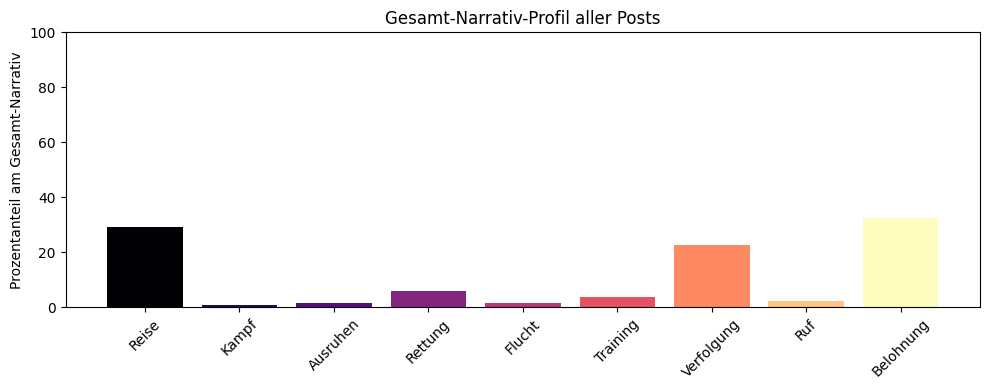

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def narrative_profile_total(posts, categories, matcher, nlp):

    # Gesamtspeicher für alle Posts
    total_hits = {c: 0 for c in categories}

    # Alle Posts durchlaufen
    for post in posts:
        doc = nlp(post)
        matches = matcher(doc)

        # Treffer im aktuellen Post
        local_hits = {c: 0 for c in categories}

        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            local_hits[label] += 1

        # lokale Treffer in Gesamtzähler addieren
        for c in categories:
            total_hits[c] += local_hits[c]

    # --- Prozentanteile berechnen ---
    total = sum(total_hits.values())
    if total == 0:
        percentages = {c: 0 for c in categories}
    else:
        percentages = {
            c: round((count / total) * 100, 2)
            for c, count in total_hits.items()
        }

    # --- Ausgabe ---
    print("\n==============================")
    print(" GESAMT-NARRATIV-PROFIL")
    print("==============================\n")

    print("Treffer gesamt:")
    for c, cnt in total_hits.items():
        print(f"{c:12}: {cnt}")

    print("\nProzentanteile gesamt:")
    for c, pct in percentages.items():
        print(f"{c:12}: {pct}%")

    # --- Diagramm zeichnen ---
    plt.figure(figsize=(10, 4))
    labels = list(categories.keys())
    values = [percentages[c] for c in labels]
    colors = plt.cm.magma(np.linspace(0, 1, len(labels)))

    plt.bar(labels, values, color=colors)
    plt.title("Gesamt-Narrativ-Profil aller Posts")
    plt.ylabel("Prozentanteil am Gesamt-Narrativ")
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return {
        "total_hits": total_hits,
        "percentages": percentages,
        "total_events": total
    }

profile = narrative_profile_total(posts, categories, matcher, nlp)


### The same aber mit Spider-Chart anstatt Balkendiagramm

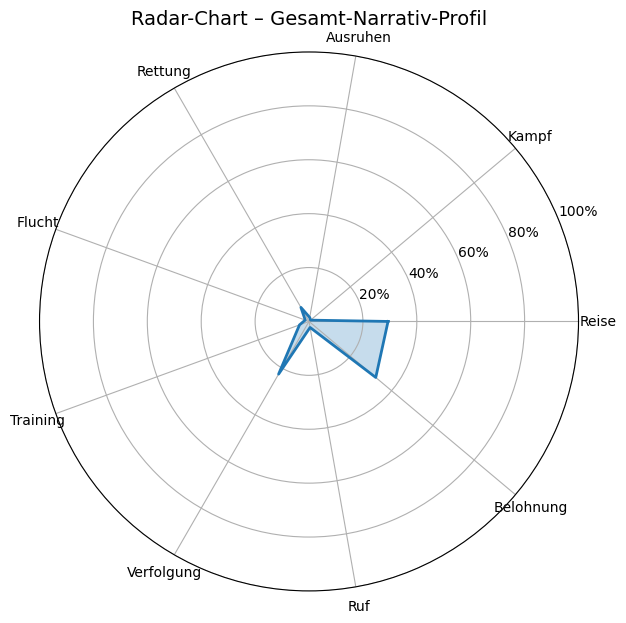

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def narrative_profile_radar(posts, categories, matcher, nlp):

    # Gesamtspeicher
    total_hits = {c: 0 for c in categories}

    # Alle Posts durchsuchen
    for post in posts:
        doc = nlp(post)
        matches = matcher(doc)

        # Treffer im Post
        local_hits = {c: 0 for c in categories}
        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            local_hits[label] += 1

        # Aufaddieren
        for c in categories:
            total_hits[c] += local_hits[c]

    # Prozentwerte berechnen
    total = sum(total_hits.values())
    if total == 0:
        percentages = {c: 0 for c in categories}
    else:
        percentages = {
            c: round((cnt / total) * 100, 2) for c, cnt in total_hits.items()
        }

    # ---- RADAR-CHART ----
    labels = list(categories.keys())
    values = [percentages[c] for c in labels]

    # Radar benötigt zyklischen Anfang/Endpunkt
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    # Linien & Fläche
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)

    # Achsen
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)

    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"])
    ax.set_ylim(0, 100)

    ax.set_title("Radar-Chart – Gesamt-Narrativ-Profil", fontsize=14, pad=20)

    plt.show()

    # Rückgabe
    return {
        "total_hits": total_hits,
        "percentages": percentages,
        "total_events": total
    }

profile = narrative_profile_radar(posts, categories, matcher, nlp)


### POS-Tagging analysieren / debuggen

In [19]:
print("---- MATCHES ----")
for match_id, start, end in matches:
    label = nlp.vocab.strings[match_id]
    span = doc[start:end]
    print(f"{label:10}  →  '{span.text}'   at {start}-{end}")

print("---- TOKENS ----")
for t in doc:
    print(f"{t.i:02d}  {t.text:12}  LEMMA={t.lemma_:12}  POS={t.pos_}")

---- MATCHES ----
---- TOKENS ----
00  @Moderatoren  LEMMA=@Moderatorum  POS=NOUN
01  :             LEMMA=--            POS=PUNCT
02  bitte         LEMMA=bitte         POS=ADV
03  hier          LEMMA=hier          POS=ADV
04  auch          LEMMA=auch          POS=ADV
05  ins           LEMMA=in            POS=ADP
06  Archiv        LEMMA=Archiv        POS=NOUN
07  verschieben   LEMMA=verschieben   POS=VERB
08  !             LEMMA=--            POS=PUNCT
09                LEMMA=              POS=SPACE
10  Alle          LEMMA=aller         POS=DET
11  Zeiten        LEMMA=Zeit          POS=NOUN
12  sind          LEMMA=sein          POS=AUX
13  UTC+02:00     LEMMA=UTC+02:00     POS=NOUN
14  Seite         LEMMA=Seite         POS=NOUN
15  12            LEMMA=12            POS=NUM
16                LEMMA=              POS=SPACE
17  von           LEMMA=von           POS=ADP
18  12            LEMMA=12            POS=NUM


# Narratologie

# Narratologische Gliederung einer epischen Geschichte

Es gibt mehrere etablierte Modelle in der Narratologie, mit denen man eine **epische Geschichte** systematisch strukturieren kann. Je nach Theorieansatz unterscheiden sich die Begriffe etwas, aber im Kern geht es immer um die **innere Struktur** (Handlungsaufbau) und die **erzählerische Darstellung** (wie erzählt wird).

---

## 1. Klassischer Handlungsaufbau (Dramaturgie der Epik)
Der klassische fünfteilige Aufbau (u. a. nach Gustav Freytag) lässt sich auch auf epische Texte übertragen:

1. **Exposition**  
   Einführung in Figuren, Raum, Zeit, Ausgangssituation, zentrale Konflikte.

2. **Steigende Handlung mit erregendem Moment**  
   Probleme spitzen sich zu; erste Wendung; Konflikt gewinnt an Dynamik.

3. **Höhepunkt / Peripetie**  
   Der entscheidende Wendepunkt der Handlung; die größte Spannung.

4. **Fallende Handlung mit retardierendem Moment**  
   Konflikte lösen sich, aber es kann Verzögerungen/Komplikationen geben.

5. **Katastrophe oder Lösung (Dénouement)**  
   Finale Klärung; tragisches oder versöhnliches Ende.

## 2. Narratologische Grundkomponenten einer Erzählung
Diese Einteilung gehört zur strukturalen Narratologie (z. B. Gérard Genette, Stanzel):

### A. Geschichte (Story / Histoire)
Inhaltsebene: **Was** passiert?

- Ereignisse / Plot  
- Figurenkonstellation (Protagonist, Antagonist, Nebenfiguren)  
- Handlungslogik / Kausalitäten  
- Settings (Ort, Zeit)  
- Motiv- und Themenstruktur  

### B. Diskurs (Discourse / Discours)
Darstellungsebene: **Wie** wird erzählt?

- **Erzählzeit vs. erzählte Zeit**  
- **Ordnung (Anachronien)**: Rückblenden (Analepse), Vorausdeutungen (Prolepse)  
- **Erzählperspektive / Fokalisierung**  
  - Ich-Erzähler  
  - Personaler Erzähler  
  - Auktorialer Erzähler  
- **Erzählverhalten**  
  - berichtend  
  - kommentierend  
  - reflektierend  
- **Darstellungsformen**  
  - Erzählerbericht  
  - direkte / indirekte Rede  
  - erlebte Rede  
  - innerer Monolog  

### C. Zeitgestaltung
- Zeitdeckung, Zeitraffung, Zeitdehnung  
- Reihenfolge  
- Dauer  


## 3. Moderne Modelle der Erzählstruktur

### A. Heldenreise (Monomythos nach Campbell/Vogler)
Typische Stationen:

1. Gewohnte Welt  
2. Ruf zum Abenteuer  
3. Verweigerung / Mentor  
4. Überschreiten der Schwelle  
5. Prüfungen, Verbündete, Feinde  
6. Tiefste Höhle / Krise  
7. Entscheidung / Wiedergeburt  
8. Rückkehr mit dem „Elixier“

### B. Dreiaktstruktur
- **Akt 1: Setup**  
  Figuren, Welt, Konflikt  
- **Akt 2: Konfrontation**  
  steigende Komplikationen, Midpoint  
- **Akt 3: Auflösung**  
  Showdown und neue Ordnung  

### C. Propp’sche Funktionen (bei Märchen)
31 mögliche Handlungsschritte (z. B. Verbot, Aufgabe, Kampf, Heimkehr). Geeignet für traditionelle epische Erzählformen.


## 4. Elemente der epischen Darstellung
Für eine epische Geschichte typisch:

- Allwissender Erzähler (häufig, aber nicht zwingend)  
- Beschreibung von Raum und Zeit  
- Breite Schilderungen  
- Szenisch-episodische Struktur  
- Dialoge und Innensicht  

## 5. Kurzfassung: Wichtigste Abschnitte

1. Exposition  
2. Konfliktentwicklung  
3. Höhepunkt  
4. Krise / Wendepunkt  
5. Lösung / Finale  
6. Erzählinstanz (Wer erzählt?)  
7. Erzählperspektive (Wie wird wahrgenommen?)  
8. Zeitgestaltung (Wann, wie schnell?)  
9. Darstellungsformen (Wie wird erzählt?)  

# Planungs- und Analysehilfe für epische Geschichten

| Abschnitt / Element                | Analysefragen / Beobachtungspunkte                                 | Planungsnotizen / Ideen |
|-----------------------------------|--------------------------------------------------------------------|------------------------|
| **Exposition**                     | Wer sind die Hauptfiguren? Wo und wann spielt die Geschichte? Was ist der Ausgangszustand? | Einführung der Figuren und Welt, Konflikte andeuten |
| **Konfliktentwicklung / steigende Handlung** | Welche Probleme oder Herausforderungen treten auf? Wie entwickeln sich Beziehungen? | Konflikte planen, Spannung aufbauen |
| **Höhepunkt / Peripetie**          | Wann erreicht die Handlung den dramatischsten Punkt? Wer oder was entscheidet? | Wendepunkt gestalten, Spannung maximieren |
| **Fallende Handlung / retardierendes Moment** | Welche Folgen hat der Höhepunkt? Gibt es weitere Komplikationen? | Übergang zur Lösung vorbereiten, Konflikte reduzieren |
| **Lösung / Dénouement**            | Wie werden Konflikte gelöst? Welches Ende ist angedacht (tragisch, versöhnlich, offen)? | Abschluss planen, Themen reflektieren |
| **Erzählinstanz**                  | Wer erzählt die Geschichte? Ist der Erzähler zuverlässig? | Erzählerrolle wählen: Ich / auktorial / personal |
| **Erzählperspektive / Fokalisierung** | Durch wessen Augen sehen wir die Handlung? Ist die Sicht konstant oder wechselnd? | Perspektivwechsel planen, Innensicht einbeziehen |
| **Zeitgestaltung**                 | Wie verläuft die Zeit? Gibt es Rückblenden oder Vorausdeutungen? | Reihenfolge, Dauer, Zeitraffung / Zeitdehnung planen |
| **Darstellungsformen**             | Welche Erzähltechniken werden genutzt? (Bericht, direkte Rede, innerer Monolog) | Mischung aus Erzählerbericht, Dialogen, Monologen planen |
| **Themen / Motive / Symbolik**     | Welche zentralen Ideen oder Symbole tauchen auf? | Leitmotive oder wiederkehrende Themen entwickeln |


----------------------------

----------------------------------------

# Elemente einer Geschichte

Es gibt viele mögliche **Abschnitte bzw. Bausteine einer Geschichte**, je nach Modell (z. B. Heldenreise, Drei-Akt-Struktur, Kishōtenketsu).  
Hier ist eine **umfangreiche Liste typischer Elemente**, die über „Reise“, „Konflikt“, „Rasten“ usw. hinausgehen.

---

## ⭐ Grundlegende erzählerische Elemente
- **Einführung / Exposition** – Vorstellung von Welt, Figuren, Status quo  
- **Auslösendes Ereignis** – der Moment, der alles in Gang setzt  
- **Steigende Handlung** – zunehmende Komplikationen  
- **Höhepunkt** – zentraler Wendepunkt oder größter Konflikt  
- **Fallende Handlung** – Aufräumen der Konsequenzen  
- **Auflösung / Denouement** – Abschluss, neuer Zustand

---

## ⭐ Elemente der Heldenreise (Joseph Campbell u. a.)
- **Ruf zum Abenteuer**  
- **Zögern / Weigerung**  
- **Mentor / Hilfe**  
- **Überschreiten der Schwelle**  
- **Prüfungen, Verbündete, Feinde**  
- **Annäherung an die tiefste Höhle**  
- **Ordeal / entscheidende Krise**  
- **Belohnung / Erkenntnis**  
- **Rückweg**  
- **Wiedergeburt / Transformation**  
- **Rückkehr mit dem Elixier**

---

## ⭐ Drei- oder Fünf-Akt-Struktur
- **Akt 1: Setup**  
  - Setting, Figuren, Problem  
- **Akt 2: Konfrontation**  
  - Komplikationen, Scheitern, Wendepunkte  
- **Akt 3: Auflösung**  
  - Entscheidung, Finale, neues Gleichgewicht  

Erweiterte 5-Akt-Variante: **Einführung – Steigerung – Höhepunkt – Retardation – Schluss**

---

## ⭐ Plot-Bausteine / narrative Funktionen
- **Foreshadowing** – Vorahnung  
- **Rote Heringe** – falsche Fährten  
- **Midpoint-Reversal** – große Wendung in der Mitte  
- **Enthüllung / Revelation**  
- **Konflikte**: intern, extern, zwischen Figuren, gegen Natur, System, sich selbst  
- **Subplots** – Nebenhandlungen  
- **Cliffhanger** – offener Spannungspunkt  
- **Twist** – überraschende Wendung  
- **Rückblende (Flashback)**  
- **Vorausdeutung (Flashforward)**  
- **Montage / Zusammenfassender Ablauf**  
- **Worldbuilding-Abschnitt**  
- **Beziehungsentwicklung**  
- **Moralisches Dilemma**

---

## ⭐ Japanische Struktur Kishōtenketsu
- **Ki – Einführung**  
- **Shō – Entwicklung**  
- **Ten – Twist / Kontrast**  
- **Ketsu – Auflösung**

---

## ⭐ Charakterbezogene Abschnitte
- **Vorstellung der Motivation**  
- **Charakterbogen / persönliche Entwicklung**  
- **Innerer Konflikt**  
- **Moment der Krise**  
- **Selbstoffenbarung / Epiphanie**  
- **Transformation**

---

## ⭐ Thematische oder atmosphärische Bausteine
- **Stimmungswechsel**  
- **Ruhige Szene („Rasten“)**  
- **Spannungsaufbau / Suspense**  
- **Humor / Comic Relief**  
- **Symbolische Szenen**  
- **Moralische oder philosophische Reflexion**

---

## ⭐ Action- und Abenteuer-spezifische Elemente
- **Training / Vorbereitung**  
- **Verfolgungsjagd**  
- **Kampf / Auseinandersetzung**  
- **Flucht**  
- **Entdeckung / Exploration**  
- **Rettung / Opfermoment**

---

> Optional: Man kann diese Elemente je nach Genre kombinieren, zu einer eigenen Story-Struktur zusammenfassen oder als Vorlage für das Schreiben verwenden.


| Element / Abschnitt              | Beschreibung                                           | Funktion / Wirkung                                     |
|---------------------------------|-------------------------------------------------------|-------------------------------------------------------|
| Einführung / Exposition          | Vorstellung von Welt, Figuren, Status quo            | Leser ins Setting einführen, Grundstimmung setzen    |
| Auslösendes Ereignis             | Ereignis, das Handlung in Gang setzt                  | Startpunkt der Geschichte, Motivation für Figuren   |
| Steigende Handlung               | Zunehmende Komplikationen                             | Spannung aufbauen, Konflikte entwickeln              |
| Höhepunkt                        | Zentraler Wendepunkt oder größter Konflikt           | Dramatischer Höhepunkt, emotionale Intensität       |
| Fallende Handlung                | Konsequenzen des Höhepunkts                           | Spannung abbauen, Konflikte lösen                    |
| Auflösung / Denouement           | Abschluss der Handlung                                 | Neuen Zustand zeigen, offene Fragen beantworten     |
| Ruf zum Abenteuer                | Figur wird zu Handlung motiviert                      | Beginn der Heldenreise                               |
| Mentor / Hilfe                   | Unterstützende Figur                                  | Figur erhält Rat, Hilfe oder Ressourcen             |
| Prüfungen / Verbündete / Feinde  | Hindernisse und Begegnungen                           | Charakterentwicklung, Spannung                       |
| Rückweg / Rückkehr mit Elixier   | Rückkehr zur Ausgangswelt mit Erfahrung/Belohnung    | Transformation der Figur zeigen                      |
| Foreshadowing / Vorausdeutung    | Hinweise auf spätere Ereignisse                       | Spannung aufbauen, Leser vorbereiten                 |
| Rote Heringe                     | Ablenkungen / falsche Hinweise                        | Überraschungseffekt, Twists                           |
| Midpoint-Reversal                | Wendepunkt in der Mitte der Geschichte               | Dramatische Kehrtwende, neue Richtung                |
| Subplot / Nebenhandlung          | parallele Geschichten                                 | Tiefe und Komplexität der Story erhöhen             |
| Cliffhanger                      | Offenes Ende einer Szene                               | Spannung steigern, Leser neugierig machen           |
| Twist / überraschende Wendung    | Unerwartete Entwicklung                               | Überraschung, Aufmerksamkeit halten                  |
| Rückblende / Flashback           | Szenen aus der Vergangenheit                          | Hintergrundinformationen, Motivation erklären       |
| Charakterbogen / Entwicklung     | Veränderung der Figur im Verlauf                       | Persönliche Transformation sichtbar machen           |
| Innerer Konflikt                 | Konflikt innerhalb der Figur                           | Tiefe, emotionale Komplexität                        |
| Ruhe / Rasten                     | Entspannung oder Pause in der Handlung               | Tempo steuern, Leser verschnaufen lassen            |
| Stimmungswechsel                 | Änderung von Atmosphäre oder Ton                      | Emotionale Wirkung verstärken                        |
| Training / Vorbereitung           | Figur übt Fähigkeiten oder bereitet sich vor         | Realistische Entwicklung, Spannung aufbauen         |
| Kampf / Konfrontation             | Auseinandersetzungen                                   | Action, Konfliktlösung                               |
| Entdeckung / Exploration          | Figur erkundet neue Orte oder Geheimnisse            | Neugier wecken, Story vorantreiben                   |


-----------

--------------

# Typische Verben und Nomen für Fantasy-Narrativ-Situationen

| Kategorie                  | Typische Verben                               | Typische Nomen                        |
|----------------------------|----------------------------------------------|--------------------------------------|
| **Reise / Aufbruch**       | reisen, wandern, ziehen, marschieren, aufbrechen | Reise, Weg, Pfad, Expedition, Marsch |
| **Kampf / Konflikt**       | kämpfen, angreifen, verteidigen, zuschlagen, stechen | Kampf, Angriff, Duell, Schlacht, Gegner, Feind |
| **Ausruhen / Erholung**    | ausruhen, rasten, schlafen, lagern, entspannen | Rast, Pause, Lager, Ruhe, Erholung |
| **Rettung / Opfer**        | retten, befreien, beschützen, opfern         | Rettung, Opfer, Heldentat, Gefahr, Bedrohung |
| **Flucht / Entkommen**     | fliehen, entkommen, wegrennen, flüchten, verstecken | Flucht, Unterschlupf, Versteck, Panik |
| **Training / Vorbereitung**| trainieren, üben, vorbereiten, meditieren    | Training, Übung, Vorbereitung, Lektion, Technik |
| **Verfolgung / Jagd**      | verfolgen, jagen, suchen, aufspüren          | Verfolgung, Jagd, Spur, Fährte |
| **Ruf zum Abenteuer**      | rufen, einladen, beauftragen, verkünden, offenbaren | Ruf, Auftrag, Prophezeiung, Vision, Botschaft |
| **Belohnung / Erkenntnis** | belohnen, erkennen, verstehen, entdecken, gewinnen | Belohnung, Schatz, Erkenntnis, Wahrheit, Einsicht |
